# Imports

In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest

In [19]:
# does not contain predicted mean_A and mean_V values:
# df = pd.read_csv("dataset/phase_3_TRAIN_7d499bff69ca69b6_6372c3e_MLPC2021_generic.csv")

# contains our predicted meanA and meanV:
df = pd.read_csv("dataset/dataset_with_predicted_mean_A_mean_V.csv")


# Split dataset into inputs and targets

In [20]:
# drop target value, student annotations and string ID from input features:
X = df.drop(columns=['quadrant','mean_A','mean_V','id','score_mode','score_key_strength', 'predicted_quadrant'])

# we want to predict the quadrant:
y = df['quadrant'].values

In [21]:
X.head()

,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,...,librosa_spectral_flatness_stdev,midlevel_features_melody,midlevel_features_articulation,midlevel_features_rhythm_complexity,midlevel_features_rhythm_stability,midlevel_features_dissonance,midlevel_features_tonal_stability,midlevel_features_minorness,predicted_mean_A,predicted_mean_V
0,0.206445,0.131383,13.998791,58.329521,3.1,0.539736,0.193987,3367.790527,3684.124268,2.986095,...,0.248388,0.065397,-0.029380,-0.303987,-0.053306,-0.325228,0.347745,-0.119278,45.216172,1.749838
1,0.145753,0.057971,3.533264,75.166183,4.2,0.476832,0.123564,1395.528809,401.987610,4.181923,...,0.000484,0.353040,-0.073957,-0.381182,0.120750,-0.479266,0.451572,-0.064252,42.078254,0.360194
2,0.149111,0.059011,3.337368,82.753929,4.3,0.457741,0.132359,1318.759644,289.306152,4.303592,...,0.000314,0.201885,0.016944,-0.337422,0.103853,-0.388214,0.430684,-0.226197,48.451175,1.963364
3,0.163914,0.057474,3.078172,79.024742,4.1,0.504427,0.121134,1258.258423,262.561310,5.271147,...,0.000257,0.181998,-0.019165,-0.314282,0.118872,-0.335902,0.314371,-0.006619,45.000775,1.033474
4,0.157382,0.054116,2.682208,59.633064,3.9,0.503377,0.121658,1244.375122,260.756195,4.122828,...,0.000241,0.256362,-0.151648,-0.302913,-0.002940,-0.395495,0.368037,-0.162711,31.551966,0.747443


In [22]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Decision Tree (no normalization): Performance: 77.79%

In [42]:
pipeline = Pipeline([
        ('classifier', tree.DecisionTreeClassifier())
      ])

param_grid = {
    'classifier__criterion':['gini','entropy'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_depth':[1,2,3,4,6,8,10,12,15,30, 60, 100, 1000],
}

grid0 = GridSearchCV(pipeline, param_grid, cv=5,n_jobs=-1, return_train_score=True, verbose=4)

grid0.fit(X, y)

print("\n"+"#"*50,"\nbest estimator: ", grid0.best_estimator_,"\n"+"#"*50,"\nbest params: ", grid0.best_params_, "\n"+"#"*50,"\nbest score: ",grid0.best_score_, "\n")


Fitting 5 folds for each of 52 candidates, totalling 260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 245 out of 260 | elapsed:    4.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 260 out of 260 | elapsed:    4.6s finished



################################################## 
best estimator:  Pipeline(memory=None,
         steps=[('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=3,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbose=False) 
################################################## 
best params:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__splitter': 'best'} 
####################################

# Normalization to [0,1] -> Feature Selection -> Decision Tree.  Performance: 77.79%

In [32]:
pipeline = Pipeline([
        ("normalizer", MinMaxScaler()),
        ("selector", SelectKBest()),
        ('classifier', tree.DecisionTreeClassifier())
      ])

param_grid = {
    'selector__k': [5,10,20,"all"],
    'classifier__criterion':['gini','entropy'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_depth':[1,2,3,4,6,8,10,12,15,30, 60, 100, 1000],
}

grid = GridSearchCV(pipeline, param_grid, cv=5,n_jobs=-1, return_train_score=True, verbose=4)

grid.fit(X, y)

print("\n"+"#"*50,"\nbest estimator: ", grid.best_estimator_,"\n"+"#"*50,"\nbest params: ", grid.best_params_, "\n"+"#"*50,"\nbest score: ",grid.best_score_, "\n")


Fitting 5 folds for each of 208 candidates, totalling 1040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    3.2s



################################################## 
best estimator:  Pipeline(memory=None,
         steps=[('normalizer', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('selector',
                 SelectKBest(k=5,
                             score_func=<function f_classif at 0x12af4ae60>)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=3,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
    

[Parallel(n_jobs=-1)]: Done 1040 out of 1040 | elapsed:    6.9s finished


# KernelPCA -> Feature Selection -> Decision Tree. Performance: 64.8% (we can skip this)

In [41]:

from sklearn.decomposition import PCA, KernelPCA

pipeline = Pipeline([
        ('kpca', KernelPCA()),
        ("selector", SelectKBest()),
        ('classifier', tree.DecisionTreeClassifier())
      ])

param_grid = {
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid", "linear", "poly"],
    'kpca__n_components': [5, 20, 40, 90],
    'selector__k': [5,10,20,"all"],
    'classifier__criterion':['gini','entropy'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_depth':[1,2,3,4,6,8,10,12,15,30, 60, 100, 1000],
}

grid2 = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=4, n_iter=100)

grid2.fit(X, y)

print("\n"+"#"*50,"\nbest estimator: ", grid2.best_estimator_,"\n"+"#"*50,"\nbest params: ", grid2.best_params_, "\n"+"#"*50,"\nbest score: ", grid2.best_score_, "\n")


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished



################################################## 
best estimator:  Pipeline(memory=None,
         steps=[('kpca',
                 KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3,
                           eigen_solver='auto', fit_inverse_transform=False,
                           gamma=0.04777777777777778, kernel='linear',
                           kernel_params=None, max_iter=None, n_components=20,
                           n_jobs=None, random_state=None,
                           remove_zero_eig=False, tol=0)),
                ('selector',
                 SelectKBest(k=5,
                             score_func=<function f_classif at 0x12af4ae60>)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=2,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,


In [ ]:
gscv_normalized = GridSearchCV(clf, param_grid, cv=5, return_train_score=True)

gscv_normalized.fit(X_normalized, y)

scores_all_features_normalized = gscv_normalized.cv_results_["mean_test_score"]

print("### all 87 features, normalized to [0, 1] ###")
print("best params:", gscv_normalized.best_params_, "\nbest score: ", gscv_normalized.best_score_,  "\n")

# Evaluation

In [43]:
def plot_search_results(grid, title="Score per parameter", log_list=[]):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle(title, fontsize=26)
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical', fontsize=18)
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper(), fontsize=18)
        if p in log_list: 
            ax[i].set_xscale('log')


    plt.legend()
    plt.show()

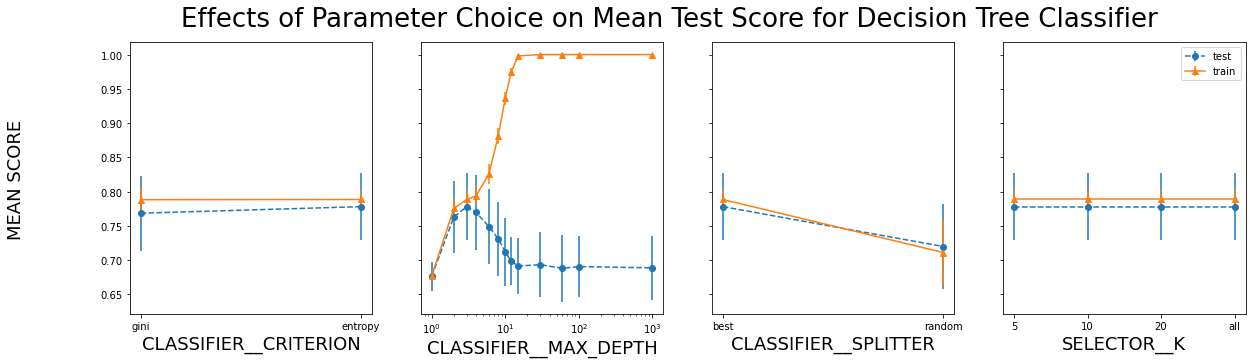

In [45]:
plot_search_results(grid, title="Effects of Parameter Choice on Mean Test Score for Decision Tree Classifier", log_list=["classifier__max_depth"])
